In [4]:
# 70. データの入手・整形
import random

with open("./rt-polaritydata/rt-polarity.pos", "r") as pos, open("./rt-polaritydata/rt-polarity.neg", "r") as neg, open("./sentiment.txt", "w") as wf:
    pos_list = ["{} {}".format("+1", line) for line in pos]
    neg_list = ["{} {}".format("-1", line) for line in neg]
    pos_list.extend(neg_list)
    random.seed(1)
    random.shuffle(pos_list)
    pos_count, neg_count = 0, 0
    for line in pos_list:
        if line.startswith("+1"):
            pos_count += 1
        elif line.startswith("-1"):
            neg_count += 1
        wf.write(line)
    print("正例: " + str(pos_count) + ", 負例: " + str(neg_count))

正例: 5331, 負例: 5331


In [7]:
# 71. ストップワード
# 英語のストップワードのリストは以下から取得した。利用する際はライセンスに注意すること
# http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/English.txt

with open("./English_stopword.txt" ,"r") as f:
    stopword_list = [word.replace("\n", "") for word in f]
    
def is_stopword(word):
    for stopword in stopword_list:
        if word == stopword:
            return True  
    return False

assert is_stopword("the"), "error"
assert is_stopword("a"), "error"
assert not is_stopword("book"), "error"
assert not is_stopword("apple"), "error"

In [8]:
# 72. 素性抽出
# ストップワードの除去とステミング

import stemming.porter2 as porter2

labels = []
sentence_list = []
with open("./sentiment.txt", "r") as f:
    for line in f:
        label, words = line.split(" ")[0], line.split(" ")[1:len(line.split(" "))] 
        words = [porter2.stem(word) for word in words if not is_stopword(word)]
        labels.append(label)
        sentence_list.append(" ".join(words))
    
idx = 0
for label, sentence in zip(labels, sentence_list):
    if idx > 5:
        break
    print(label + "\t" + sentence)
    idx += 1

-1	film press familiar herzog trope servic limpid convent histor fiction , demand director mesmeris . 

+1	work magic exuber passion film length part fun . 

-1	elabor special effect centr screen , human stori push side . 

+1	stand year intrigu movi experi , let imageri speak forc ponder anew movi . 

-1	bodi episod tv show blind date , technic profici pop-up comment . 

-1	chocol factori charli . 



In [9]:
# 素性としてbi-gramを使用する
# http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
features = bigram_vectorizer.fit_transform(sentence_list).toarray()

In [10]:
# 73. 学習
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
# 74. 予測 & 76. ラベル付け

idx = 0
for label, feature in zip(labels, features):
    if idx > 5:
        break
    predict_label = clf.predict(feature.reshape(1,len(feature)))
    predict_prob = clf.predict_proba(feature.reshape(1,len(feature)))
    print("{}\t{}\t{}".format(label, predict_label, predict_prob))
    idx += 1

-1	['-1']	[[ 0.11417759  0.88582241]]
+1	['+1']	[[ 0.96510091  0.03489909]]
-1	['-1']	[[ 0.25794333  0.74205667]]
+1	['+1']	[[ 0.95698306  0.04301694]]
-1	['-1']	[[ 0.03319744  0.96680256]]
-1	['-1']	[[ 0.17183861  0.82816139]]


In [12]:
# 75. 素性の重み

import math

feature_names = bigram_vectorizer.get_feature_names()
coefs = clf.coef_[0]

coef_list = [(feature_name, math.fabs(coef)) for feature_name, coef in zip(feature_names, coefs)]
sorted_coefs = sorted(coef_list, key=lambda x:x[1], reverse=True)

print("====重みの高い素性トップ10====")
for coef in sorted_coefs[:10]:
    print("{}\t{}".format(coef[0], coef[1]))
    
print("\n====重みの低い素性トップ10====")
for idx,coef in enumerate(reversed(sorted_coefs)):
    if idx > 9:
        break
    print("{}\t{}".format(coef[0], coef[1]))

====重みの高い素性トップ10====
refresh	2.1253535561175476
bore	2.0744694728539117
dull	1.8331431061908945
wonder	1.8303227754041198
beauti	1.732565779219767
unexpect	1.7157308521651549
engross	1.695388160164467
mediocr	1.6053869276976755
bad	1.6014813842761986
worst	1.551963302029867

====重みの低い素性トップ10====
film delight	2.327947711773116e-06
orphan	4.73762989202611e-06
archiv	1.4003476287149566e-05
twist charact	3.602030408714188e-05
unexpect move	4.085919218731578e-05
resist artist	4.085919218731578e-05
move medit	4.085919218731578e-05
memori resist	4.085919218731578e-05
made sheer	4.085919218731578e-05
love histori	4.085919218731578e-05


In [13]:
# 77. 正解率の計測

from sklearn.metrics import classification_report 

clf = LogisticRegression()
clf.fit(features, labels)
pred = clf.predict(features)
print("正解率: " + str(clf.score(features, labels)))
print(classification_report(labels, pred, target_names=["+1", "-1"]))

正解率: 0.996435940724
             precision    recall  f1-score   support

         +1       1.00      0.99      1.00      5331
         -1       0.99      1.00      1.00      5331

avg / total       1.00      1.00      1.00     10662



In [14]:
# 78. 5分割交差検定

from sklearn.cross_validation import StratifiedKFold
import numpy as np
from sklearn import cross_validation as cv

clf =  LogisticRegression()
skf = StratifiedKFold(labels, n_folds=5)
print("正解率: " + str(np.mean(cv.cross_val_score(clf, features, [int(label) for label in labels], cv=skf, scoring="accuracy"))))
print("適合率: " + str(np.mean(cv.cross_val_score(clf, features, [int(label) for label in labels], cv=skf, scoring="precision"))))
print("再現率: " + str(np.mean(cv.cross_val_score(clf, features, [int(label) for label in labels], cv=skf, scoring="recall"))))
print("F1スコア: " + str(np.mean(cv.cross_val_score(clf, features, [int(label) for label in labels], cv=skf, scoring="f1"))))

正解率: 0.754078961019
適合率: 0.755762884235
再現率: 0.751079898226
F1スコア: 0.753354917358


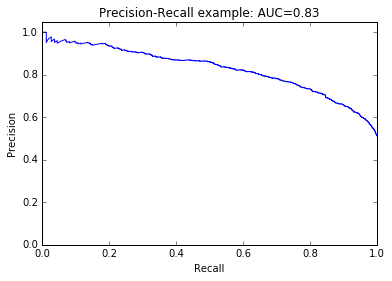

In [20]:
# 79. 適合率-再現率グラフの描画

from sklearn.metrics import precision_recall_curve
from sklearn.cross_validation import train_test_split
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline

clf = LogisticRegression()
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)
pred_probs = clf.fit(features_train, labels_train).predict_proba(features_test.reshape(len(features_test), len(features_test[0])))

# precision_recall_curve()に渡すラベルの中身は決められたレンジのintでなければならない
precision, recall, thresholds = precision_recall_curve([int(label) for label in labels_test], pred_probs[:, 0])
area = auc(recall, precision)

plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC=%0.2f' % area)
plt.show()